<a href="https://colab.research.google.com/github/dennistay1981/Resources/blob/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Data_science_approaches_to_mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descriptive analytics: cross-tabulating metaphor sources and targets

In [ ]:
#Import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Descriptive.csv')

# Cross-tabulation
crosstab = pd.crosstab(data['SOURCE'], data['TARGET'])

# Observed frequencies
observed = crosstab.values

# Expected frequencies
chi2, p, dof, expected = chi2_contingency(observed)

# Pearson's residuals
residuals = (observed - expected) / np.sqrt(expected)

# Cramer's V
n = observed.sum()
phi2 = chi2 / n
r, k = observed.shape
phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
rcorr = r - ((r - 1)**2) / (n - 1)
kcorr = k - ((k - 1)**2) / (n - 1)
cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Heatmap with observed frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Cross-tabulation of Metaphor Sources and Targets')
plt.xlabel('Target')
plt.ylabel('Source')
plt.show()

# Heatmap with Pearson's residuals
plt.figure(figsize=(12, 8))
sns.heatmap(residuals, annot=True, fmt=".2f", cmap='Reds', cbar=True)
plt.title('Pearson Residuals')
plt.xlabel('Target')
plt.ylabel('Source')
plt.show()

print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramer's V: {cramer_v:.3f}")

Diagnostic (ARM)


In [ ]:
#Import Python libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Diagnostic.csv')

#Split ASD and non-ASD individuals into two dataframes
data_ASD = data.loc[data['ASD']=='Y']
data_NASD = data.loc[data['ASD']=='N']

#convert transactions into lists: one for ASD, one for Non-ASD, and one for the overall dataset
transactions_ASD = data_ASD['sources'].apply(lambda t: t.split(','))
transactions_NASD = data_NASD['sources'].apply(lambda t: t.split(','))
transactions_all = data['sources'].apply(lambda t: t.split(','))

# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(transactions_ASD)
encoder2 = TransactionEncoder().fit(transactions_NASD)
encoder3 = TransactionEncoder().fit(transactions_all)


# One-hot encode transactions
onehot_ASD = encoder.transform(transactions_ASD)
onehot_NASD = encoder2.transform(transactions_NASD)
onehot_all = encoder3.transform(transactions_all)

# Convert one-hot encoded data to DataFrame
onehot_ASD = pd.DataFrame(onehot_ASD, columns = encoder.columns_)
onehot_NASD = pd.DataFrame(onehot_NASD, columns = encoder2.columns_)
onehot_all = pd.DataFrame(onehot_all, columns = encoder3.columns_)


# Compute frequent itemsets using the Apriori algorithm
# i.e. what are the items (max length 3) that (jointly) appear in at least 5% of transactions
frequent_itemsets_ASD = apriori(onehot_ASD, min_support = 0.05, max_len = 3, use_colnames = True)  #minimum support value, maximum itemset length to be retained
frequent_itemsets_NASD = apriori(onehot_NASD, min_support = 0.05, max_len = 3, use_colnames = True)
frequent_itemsets_all = apriori(onehot_all, min_support = 0.05, max_len = 3, use_colnames = True)

# Compute all association rules for frequent_itemsets, limiting only to rules with support > 0.05
# i.e. both antecedent and consequent items jointly appear in at least 5% of transactions
rules_ASD = association_rules(frequent_itemsets_ASD, metric = "support", min_threshold = 0.05)
rules_NASD = association_rules(frequent_itemsets_NASD, metric = "support", min_threshold = 0.05)
rules_all = association_rules(frequent_itemsets_all, metric = "support", min_threshold = 0.05)

# Replace frozen sets with strings
rules_ASD['antecedents'] = rules_ASD['antecedents'].apply(lambda a: ','.join(list(a)))
rules_ASD['consequents'] = rules_ASD['consequents'].apply(lambda a: ','.join(list(a)))
rules_NASD['antecedents'] = rules_NASD['antecedents'].apply(lambda a: ','.join(list(a)))
rules_NASD['consequents'] = rules_NASD['consequents'].apply(lambda a: ','.join(list(a)))
rules_all['antecedents'] = rules_all['antecedents'].apply(lambda a: ','.join(list(a)))
rules_all['consequents'] = rules_all['consequents'].apply(lambda a: ','.join(list(a)))

# Sort rules by confidence, then lift, then support in descending order
rules_ASD = rules_ASD.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])
rules_NASD = rules_NASD.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])
rules_all = rules_all.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])



Predictive (survival regression)


In [ ]:
#Install lifelines library
!pip install lifelines

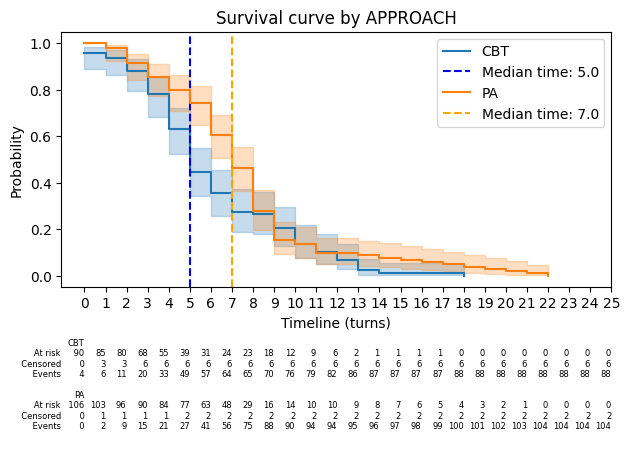

In [31]:
#Import Python libraries
from lifelines import KaplanMeierFitter
import pandas as pd
import seaborn as sns

#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Predictive.csv')

#Initiate and fit. durations=time, event_observed= event of interest, 1 (occurred) or 0 (not)
kmf = KaplanMeierFitter()
kmf.fit(durations=data['Turns'], event_observed=data['Attrition'])

#Cumulative distribution function of survived turns by Initiator and Approach
sns.ecdfplot(data, x='Turns', hue='Initiator')
sns.ecdfplot(data, x='Turns', hue='Approach')







"""
Plot survival function with subgroups and median lines (INITIATOR)
"""
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'].Turns,
               event_observed=data.loc[data.Initiator =='T'].Attrition, label='Therapist').plot_survival_function(ax=ax)
ax.axvline(kmf_A.median_survival_time_, linestyle='--', color='blue', label=f'Median time: {kmf_A.median_survival_time_:.1f}')

kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'].Turns,
               event_observed=data.loc[data.Initiator =='C'].Attrition, label='Client').plot_survival_function(ax=ax)
ax.axvline(kmf_B.median_survival_time_, linestyle='--', color='orange', label=f'Median time: {kmf_B.median_survival_time_:.1f}')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 26))
plt.title('Survival curve by INITIATOR')

#to add risk counts table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_A, kmf_B, ax=ax, fontsize=6)
plt.tight_layout()
plt.show()


"""
Plot survival function with subgroups and median lines  (APPROACH)
"""
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Approach =='CBT'].Turns,
               event_observed=data.loc[data.Approach =='CBT'].Attrition, label='CBT').plot_survival_function(ax=ax)
ax.axvline(kmf_A.median_survival_time_, linestyle='--', color='blue', label=f'Median time: {kmf_A.median_survival_time_:.1f}')

kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Approach =='PA'].Turns,
               event_observed=data.loc[data.Approach =='PA'].Attrition, label='PA').plot_survival_function(ax=ax)

ax.axvline(kmf_B.median_survival_time_, linestyle='--', color='orange', label=f'Median time: {kmf_B.median_survival_time_:.1f}')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 26))
plt.title('Survival curve by APPROACH')

#to add risk counts table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_A, kmf_B, ax=ax, fontsize=6)
plt.tight_layout()
plt.show()



